## Neuromaps Tutorial
    Markello, RD, Hansen, JY, Liu, ZQ, Bazinet, V, Shafiei, G, Suarez, LE, Blostein, N, Seidlitz, J, Baillet, S, Satterthwaite, TD & Chakravarty, M. (2022). Neuromaps: structural and functional interpretation of brain maps. Biorxiv. doi:10.1101/bioRxiv.475081

    https://github.com/netneurolab/neuromaps

    https://netneurolab.github.io/neuromaps/index.html

---
#### Basic functionality of Neuromaps
* Access to curated repository of annotations from recent literature
* Transformations between coordinate systems
* Comparing brain maps (with spatial nulls for significance testing)
---

All of these coordinate systems have multiple resolutions (or densities), and the neuromaps distributions supports data in the following representations:

1. MNI152: 1mm, 2mm, 3mm (isotropic voxel sizes)
2. fsLR: 4k, 8k, 32k, 164k (number of vertices per hemisphere)
3. fsaverage: 1k, 3k, 10k, 41k, 164k (number of vertices per hemisphere)
4. CIVET: 41k (number of vertices per hemisphere)

#### Find Relevant Annotations

In [1]:
from neuromaps.datasets import available_tags, available_annotations

When new brain maps are added to the Neuromaps repository, they are uploaded in their original coordinate system and organized into groups by tag which gives us a little more information on the kind of data they represent. Use <code>available_tags()</code> and <code>available_annotations()</code> to find annotations that best match a specific interest.

    "These maps offer insights into the brain’s structural and functional architecture, including grey matter morphometry, myelination, gene expression, cytoarchitecture, metabolism, neurotransmitter receptors and transporters, laminar differentiation, intrinsic dynamics and evolutionary expansion."

In [75]:
# all available tags
all_tags = available_tags()
print(all_tags)

# sort through all available annotations

all_annotations = available_annotations()
all_annotations[:5]

['ASL', 'MEG', 'MRI', 'PET', 'fMRI', 'functional', 'genetics', 'meta-analysis', 'receptors', 'structural']


[('abagen', 'genepc1', 'fsaverage', '10k'),
 ('aghourian2017', 'feobv', 'MNI152', '1mm'),
 ('alarkurtti2015', 'raclopride', 'MNI152', '3mm'),
 ('bedard2019', 'feobv', 'MNI152', '1mm'),
 ('beliveau2017', 'az10419369', 'MNI152', '1mm')]

---
Annotations are displayed as len-4 tuple values:

(source of annotation, brief description, coordinate system, density/resolution)

---

In [83]:
# find annotations by tags and desc

for annotation in available_annotations(tags=['genetics'], desc='genepc1'):
    print(annotation)

('abagen', 'genepc1', 'fsaverage', '10k')


In [79]:
# find annotations by source, desc, space, den, res, hemi, tags, or format

for annotation in available_annotations(source='savli2012',tags=['receptors'], space='MNI152', res='3mm'):
    print(annotation)

('savli2012', 'altanserin', 'MNI152', '3mm')
('savli2012', 'dasb', 'MNI152', '3mm')
('savli2012', 'p943', 'MNI152', '3mm')
('savli2012', 'way100635', 'MNI152', '3mm')


#### Accessing Annotations

Once you have have selected your annotations of interest, use <code>neuromaps.datasets.fetch_annotation()</code>, with the corresponding keyword arguments <code>(source='', desc='',...)</code> to access it. Note that if the publisher provided more than one annotation to Neuromaps, only passing in <code>source=''</code> will return a dictionary rather than a single image or tuple of images.

In [81]:
from neuromaps.datasets import fetch_annotation

# receptor maps
gaba_receptor_map = fetch_annotation(source='dukart2018', desc='flumazenil')
dop_receptor_map = fetch_annotation(source='kaller2017')

# first principal component - gene expression map
gene_map = fetch_annotation(source='abagen')

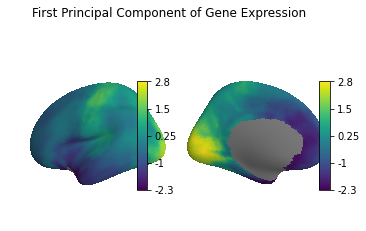

In [59]:
gene_plt = plotting.plot_surf_template(gene_map, 'fsaverage', '10k', colorbar=True,
                                       hemi='L', title='First Principal Component of Gene Expression')

#### Transformations between coordinate systems

In [60]:
from neuromaps import transforms

* <code>neuromaps.transforms.mni152_to_civet(), fsaverage(), fslr(), mni152()</code>


* <code>neuromaps.transforms.fsaverage_to_fslr(), civet(), fsaverage()</code>


* <code>neuromaps.transforms.fslr_to_civet(), fsaverage(), fslr()</code>


* <code>neuromaps.transforms.civet_to_fslr(), fsaverage(), civet()</code>


In [61]:
# from mni152 to fsaverage, fslr, civet

# gaba receptor map transforms

gaba_fsav = transforms.mni152_to_fsaverage(gaba_receptor_map, '10k')
gaba_fslr = transforms.mni152_to_fslr(gaba_receptor_map, '32k')
gaba_civet = transforms.mni152_to_civet(gaba_receptor_map, '41k')

# dopamine receptor map transforms

dop_fsav = transforms.mni152_to_fsaverage(dop_receptor_map, '10k')
dop_fslr = transforms.mni152_to_fslr(dop_receptor_map, '32k')
dop_civet = transforms.mni152_to_civet(dop_receptor_map, '41k')

In [62]:
# to/from fsaverage, fslr, civet

gene_fslr = transforms.fsaverage_to_fslr(gene_map, '32k')
gene_civet = transforms.fsaverage_to_civet(gene_map, '41k')

#### Parcellations

In addition to transformations, you may want to parcellate your data to a corresponding atlas. Here, we will use <code>abagen.fetch_desikan_killiany</code> to fetch a parcellation file and <code>neuromaps.parcellate</code> to implement it to a map of Alzheimer's association regions from <a href='https://neurosynth.org'>Neurosynth</a>. We will do the same thing to the dopamine receptor map that we fetched above.

In [142]:
import abagen
import nibabel as nib
atlas = abagen.fetch_desikan_killiany()

In [143]:
from neuromaps.parcellate import Parcellater
parc = Parcellater(atlas['image'], 'mni152')


AD_association = nib.load('data/neurosynth_maps/terms/alzheimer_association-test_z_FDR_0.01.nii')

In [144]:
AD_association.shape, nib.load(dop_receptor_map).shape

((91, 109, 91), (61, 73, 61))

Since <code>AD_association</code> and <code>dop_receptor_map</code> are of different shapes, we need to use <code>neuromaps.resampling.resample_images</code> before parcellating the data.

In [145]:
# dop_receptor_map_resamp = transforms.mni152_to_mni152(dop_receptor_map, '3mm')
# AD_association_resamp = transforms.mni152_to_mni152(AD_association, '3mm')

from neuromaps.resampling import resample_images
dop_res, AD_res = resample_images(src=dop_receptor_map, trg=AD_association,
                                  src_space='MNI152', trg_space='MNI152',
                                  method='linear', resampling='downsample_only')
dop_res.shape, AD_res.shape

((61, 73, 61), (61, 73, 61))

In [146]:
AD_parc = parc.fit_transform(AD_res, 'mni152')
dop_parc = parc.fit_transform(dop_res, 'mni152')

In [147]:
AD_parc[0].shape, dop_parc[0].shape

((83,), (83,))

#### Comparing Brain Maps
To assess the statistical relationship between two brain annotations in the same coordinate system we can use <code>neuromaps.stats.compare_images</code>

In [149]:
from neuromaps.stats import compare_images

# compare parcellated dopamine and AD maps

compare_images(dop_parc, AD_parc)

-0.10360589350588262

In [175]:
# compare non-parcellated dopamine and AP maps

compare_images(AD_res,dop_res)

0.06810005224243088

#### Spatial Null Models

    "When working with parcellated data, the null framework that seems to consistently yield statistical estimates with the lowest error rate is the Cornblath method.

    When working with vertex-level data, the optimal null method appears to be the framework proposed by Alexander-Bloch et al., 2018

    However, if you have volumetric, subcortical, cerebellar, or region-of-interest data you can only use the parameterized data models in these situations. Here, we find that the Moran and Burt-2020 methods seem to fare rather comparably"

            - https://markello-spatialnulls.netlify.app/recommendations.html

In order to test the significance of these statistical associations, it is neccesary to assess and account for spatial autocorrelation, because data points that are close together in these brain maps may not be statistically independent. For this example, let's look at two of the available annotations in the CIVET coordinate system. These are both from a paper titled, "Normative brain size variation and brain shape diversity in humans," by P. K. Reardon et al. <code>civet1</code> is a brain map from the National Institutes of Health (NIH) sample of 1531 longitudinally acquired brain scans and <code>civet2</code> is an independent magnetic resonance imaging (MRI) dataset from the Human Connectome Project (HCP) (n = 1113).

In [176]:
from neuromaps import stats, nulls

In [177]:
civet1 = fetch_annotation(source='reardon2018', desc='scalinghcp')
civet2 = fetch_annotation(source='reardon2018', desc='scalingnih')

In [178]:
# compare without providing null model

stats.compare_images(civet1,civet2)

0.3770379047549592

#### Spatial Null Model

In [179]:
rotated = nulls.alexander_bloch(civet1, atlas='civet', density='41k',
                                n_perm=100, seed=1234)

r, p = stats.compare_images(civet1,civet2, nulls=rotated)
print(f'Correlation: {r}, P-value: {p}')

Correlation: 0.3770379047549592, P-value: 0.009900990099009901


#### non-parametric - neuromaps stats method
Calculates two-tailed p-value for hypothesis of whether samples a and b are related using permutation tests

In [170]:
# array data from civet1, civet2 annotations

img_civet1a = nib.load(civet1[0])
img_civet1b = nib.load(civet1[1])
img_civet1 = img_civet1a.agg_data() + img_civet1b.agg_data()

img_civet2a = nib.load(civet2[0])
img_civet2b = nib.load(civet2[1])
img_civet2 = img_civet2a.agg_data() + img_civet2b.agg_data()

In [171]:
r, p = stats.permtest_metric(img_civet1, img_civet2)

In [172]:
r, p

(0.5343663096427917, 0.000999000999000999)